In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../wanpy")

from wanpy import *
from pythtb import *
from wpythtb import *
import models
import numpy as np
import matplotlib.pyplot as plt

/Users/treycole/Repos/WanPy/tutorials


# Haldane model

Setting up `pythTB` tight-binding model for the Haldane model parameterized by the onsite potential $\Delta$, nearest neighbor hopping $t_1$ and complex next nearest neighbor hopping $t_2$

In [9]:
# tight-binding parameters
delta = t1 = 1
t2 = -0.1
n_super_cell = 2  # number of primitive cells along both lattice vectors

model = models.Haldane(delta, t1, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

# `Wannier` class

The `Wannier`class contains the functions relevant for subspace selection, maximal-localization, and Wannier interpolation. We initialize it by passing the reference `Model` and number of k-points along each dimension in the mesh.

In [3]:
nks = 20, 20  # number of k points along each dimension
WF = Wannier(model, nks)

Each `Wannier` instance has the following attributes 
- `model`: reference to the `Model`
- `K_mesh`: a `K_mesh` instance on which the Bloch eigenstates are defined
- `supercell`: a list of tuples defining the supercell conjugate to the discrete k-mesh
- `energy_eigstates`: a `Bloch` instance containing the energy eigenstates
-  `tilde_states`: a `Bloch` instance containing the Bloch-like states corresponding to the Wannier functions.

In [4]:
from pprint import pprint
pprint(list(vars(WF).keys()))

['model', '_nks', 'K_mesh', 'energy_eigstates', 'tilde_states', 'supercell']


## Setting up trial wavefunctions 

Now we must choose trial wavefunctions to construct our Bloch-like states. A natural choice is delta functions on the low-energy sublattice in the home cell. 

The trial wavefunctions are defined by lists of tuples specifying the trial wavefunction's probability amplitude over the orbitals `[(n, c_n), ...]`. 

$$ |t_i \ \rangle = \sum_n c_n |\phi_n\rangle $$


_Note_: Normalization is handled internally so the square of the amplitudes do not need to sum to $1$. Any orbitals not specified are taken to have zero amplitude.

In [10]:
# model specific constants
n_orb = model.get_num_orbitals()  # number of orbitals
n_occ = int(n_orb/2)  # number of occupied bands (assume half-filling)
low_E_sites = np.arange(0, n_orb, 2)  # low-energy sites defined to be indexed by even numbers

# defining the trial wavefunctions
tf_list = [[(orb, 1)] for orb in low_E_sites]
n_tfs = len(tf_list)

print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {n_tfs/n_occ}")

Trial wavefunctions: [[(np.int64(0), 1)], [(np.int64(2), 1)], [(np.int64(4), 1)], [(np.int64(6), 1)]]
# of Wannier functions: 4
# of occupied bands: 4
Wannier fraction: 1.0


## Projection step

To obtain the initial Bloch-like states from projection we call the method `single_shot` providing the trial wavefunctions we specified and the band-indices to construct Wannier functions from. This performs the operations,
1. Projection $$ (A_{\mathbf{k}})_{mn} = \langle \psi_{m\mathbf{k}} | t_n \rangle$$
2. SVD $$ A_{\mathbf{k}} = V_{\mathbf{k}} \Sigma_{\mathbf{k}} W_{\mathbf{k}}^{\dagger} $$
3. Unitary rotation$$ |\tilde{\psi}_{n\mathbf{k}} \rangle = \sum_{m\in \text{band idxs}} |\psi_{m\mathbf{k}} \rangle (V_{\mathbf{k}}W_{\mathbf{k}}^{\dagger})_{mn} $$
4. Fourier transformation $$  |\mathbf{R} n\rangle = \sum_{\mathbf{k}} e^{-i\mathbf{k}\cdot \mathbf{R}} |\tilde{\psi}_{n\mathbf{k}} \rangle  $$

In [11]:
WF.single_shot(tf_list, band_idxs=list(range(n_occ)))

AttributeError: 'Bloch' object has no attribute 'K_mesh'

This will already gives us quite localized Wannier functions. We can see their spreads by calling the function `report`.

In [7]:
WF.report()

Wannier function report
 --------------------- 
Quadratic spreads:
w_0 --> 0.10437
w_1 --> 0.10437
w_2 --> 0.10437
w_3 --> 0.10437
Centers:
w_0 --> [0.16667 0.16667]
w_1 --> [0.16667 0.66667]
w_2 --> [0.66667 0.16667]
w_3 --> [0.66667 0.66667]
Omega_i = 0.3723288655936301
Omega_tilde = 0.0451622119762989


In [8]:
WF.get_Omega_I()

np.complex128(0.3723288655936401+3.349544535761715e-17j)

We can also directly access the attributes

In [8]:
print(WF.spread)
print(WF.omega_i)
print(WF.omega_til)
print(WF.centers)

omega_til_ss = WF.omega_til

[0.10437277 0.10437277 0.10437277 0.10437277]
0.3723288655936301
0.0451622119762989
[[0.5        0.28867513]
 [1.         1.15470054]
 [1.5        0.28867513]
 [2.         1.15470054]]


We can visualize the Wannier density using `plot_density`. We specify which Wannier function to look at with `Wan_idx`.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$|\\mathbf{r}- \\mathbf{{r}}_c|$', ylabel='$|w_0(\\mathbf{r}- \\mathbf{r}_c)|^2$'>)

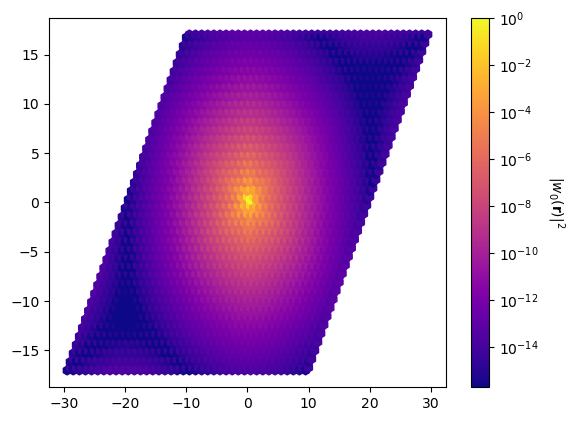

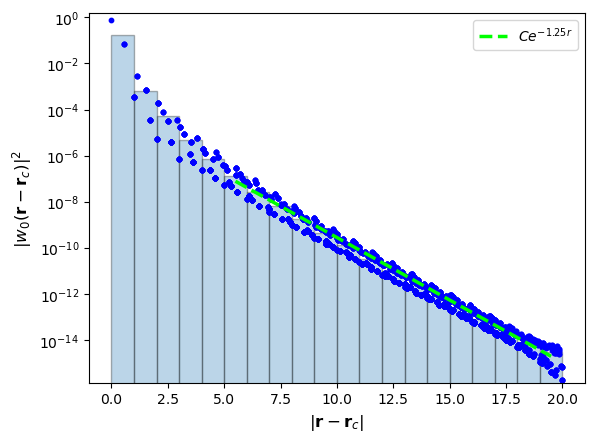

In [9]:
WF.plot_density(Wan_idx=0)
WF.plot_decay(Wan_idx=0, fit_rng=[5,20])

## Maximal Localization

_Maximal localization_ finds the optimal unitary rotation that minimizes the gauge dependent spread $\widetilde{\Omega}$. To do so we call the `max_loc` function, specifying the following
- `eps` is the step size for gradient descent
- `iter_num` is the number of iterations before the calculation stops
- Optionally we can set `tol` specifying the minimum change in the spread at subsequent iterations before convergence
- For additional control we specify `grad_min` which sets the minimum gradient of the spread before convergence.

In [10]:
iter_num = 1000

WF.max_loc(eps=1e-3, iter_num=iter_num, tol=1e-10, grad_min=1e-10, verbose=True)

0 Omega_til = 0.045132897092439485, Grad mag: 13.967154388064257
1 Omega_til = 0.04510725451010692, Grad mag: 13.884131680936214
2 Omega_til = 0.04508226018550888, Grad mag: 13.809853104900542
3 Omega_til = 0.045057883851669304, Grad mag: 13.735969940514842
4 Omega_til = 0.04503409767794846, Grad mag: 13.662480162573504
5 Omega_til = 0.045010875978799464, Grad mag: 13.589381751432933
6 Omega_til = 0.04498819496795524, Grad mag: 13.516672693415115
7 Omega_til = 0.044966032550950386, Grad mag: 13.444350981162577
8 Omega_til = 0.04494436814726959, Grad mag: 13.372414613950196
9 Omega_til = 0.04492318253710039, Grad mag: 13.300861597960163
10 Omega_til = 0.044902457729234596, Grad mag: 13.229689946524367
11 Omega_til = 0.04488217684564905, Grad mag: 13.158897680338429
12 Omega_til = 0.0448623240206002, Grad mag: 13.08848282765064
13 Omega_til = 0.04484288431197478, Grad mag: 13.018443424428934
14 Omega_til = 0.044823843622823156, Grad mag: 12.94877751450814
15 Omega_til = 0.044805188631739

Now let's see how the localization improved.

In [11]:
WF.report()

omega_til_ml = WF.omega_til
print()
print(f"Spread lowered by: {omega_til_ss-omega_til_ml}")

Wannier function report
 --------------------- 
Quadratic spreads:
w_0 --> 0.10396
w_1 --> 0.10396
w_2 --> 0.10396
w_3 --> 0.10396
Centers:
w_0 --> [0.16667 0.16667]
w_1 --> [0.16667 0.66667]
w_2 --> [0.66667 0.16667]
w_3 --> [0.66667 0.66667]
Omega_i = 0.3723288655954775
Omega_tilde = 0.04352461090023928

Spread lowered by: 0.0016376010760596194


# Reduced Wanner functions and subspace selection

In [1]:
# tight-binding parameters
delta = 1
t1 = 1
t2 = -0.4

n_super_cell = 2
model = models.Haldane(delta, t1, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

# model specific constants
n_orb = model.get_num_orbitals()  # number of orbitals
n_occ = int(n_orb/2)  # number of occupied bands (assume half-filling)
lat_vecs = model.get_lat()  # lattice vectors
orb_vecs = model.get_orb()  # orbital vectors

# Chern number
u_wfs_full = wf_array(model, [20, 20]) # container for wavefunctions
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)
print(f"Chern number: {chern:0.3f}")

NameError: name 'models' is not defined

Since the occupied manifold is obstructed, we must use restricted projection in order to Wannierize a subspace. For example, let's Wannierize a 3-dimensional subspace by choosing trial wavefunctions centered on 3 of the low energy orbitals.

In [ ]:
low_E_sites = np.arange(0, n_orb, 2)  # low-energy sites defined to be indexed by even numbers
omit_site = 6  # omitting one of the low energy sites
tf_list = list(np.setdiff1d(low_E_sites, [omit_site])) 

n_tfs = len(tf_list)

print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {n_tfs/n_occ}")

Trial wavefunctions: [np.int64(0), np.int64(2), np.int64(4)]
# of Wannier functions: 3
# of occupied bands: 4
Wannier fraction: 0.75


As before, instantiate the Wannier class and start with the initial projection

In [14]:
nks = 20, 20  # number of k points along each dimension
WF = Wannier(model, nks)

WF.single_shot(tf_list, band_idxs=list(range(n_occ)))

Now we have an initial subspace. We can use disentanglement, or subspace selection, to find the subspace with the minimal gauge-dependent spread $\Omega_I$

In [15]:
# subspace selection
WF.subspace_selec(iter_num=200, tol=1e-10, verbose=True)

0 Omega_I: 0.7351242262300735
1 Omega_I: 0.7318708508836085
2 Omega_I: 0.7290033204981925
3 Omega_I: 0.7264422430421329
4 Omega_I: 0.7241292655802021
5 Omega_I: 0.7220202214129884
6 Omega_I: 0.7200809965885995
7 Omega_I: 0.7182848310727434
8 Omega_I: 0.7166104648979883
9 Omega_I: 0.715040820806551
10 Omega_I: 0.713562045435658
11 Omega_I: 0.7121627987871728
12 Omega_I: 0.710833720078442
13 Omega_I: 0.7095670213309611
14 Omega_I: 0.7083561748922823
15 Omega_I: 0.7071956709131344
16 Omega_I: 0.7060808274938559
17 Omega_I: 0.7050076408723117
18 Omega_I: 0.7039726663213658
19 Omega_I: 0.7029729227918393
20 Omega_I: 0.7020058160559315
21 Omega_I: 0.7010690763684231
22 Omega_I: 0.7001607075986658
23 Omega_I: 0.6992789454844384
24 Omega_I: 0.6984222231853883
25 Omega_I: 0.697589142712609
26 Omega_I: 0.6967784511152222
27 Omega_I: 0.6959890205392768
28 Omega_I: 0.6952198314554152
29 Omega_I: 0.6944699584920434
30 Omega_I: 0.6937385584217078
31 Omega_I: 0.6930248599344689
32 Omega_I: 0.69232815

To obtain maximally localized Wannier functions, we follow this with another projection to initialize a smooth gauge, then maximal localization.
- Note we must pass the flag `tilde=True` to indicate we are projecting the trial wavefunctions onto the tilde states and not the energy eigenstates

In [16]:
WF.single_shot(tf_list, tilde=True)
WF.max_loc(eps=1e-3, iter_num=1000, tol=1e-10, grad_min=1e-10, verbose=False)

Omega_tilde minimization has converged within tolerance. Breaking the loop.


In [17]:
WF.report()

Wannier function report
 --------------------- 
Quadratic spreads:
w_0 --> 0.23446
w_1 --> 0.23446
w_2 --> 0.23446
Centers:
w_0 --> [0.16268 0.16268]
w_1 --> [0.16268 0.67465]
w_2 --> [0.67465 0.16268]
Omega_i = 0.659749507346163
Omega_tilde = 0.04362623757210355


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$|\\mathbf{r}- \\mathbf{{r}}_c|$', ylabel='$|w_0(\\mathbf{r}- \\mathbf{r}_c)|^2$'>)

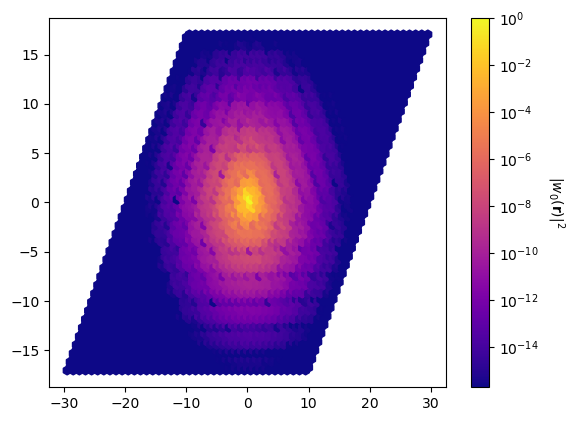

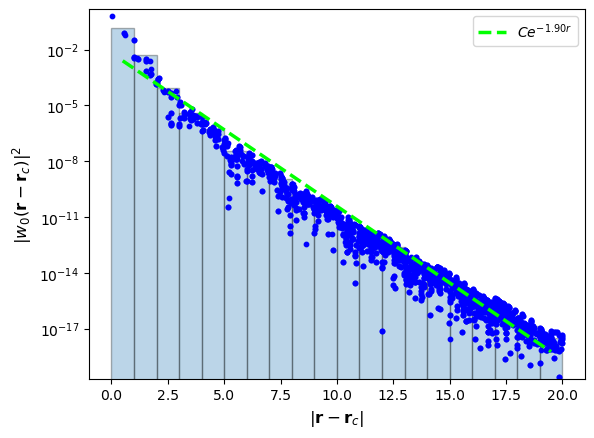

In [18]:
WF.plot_density(0)
WF.plot_decay(0, fit_rng=[0,20])

## Wannier interpolation

We can view the Wannier interpolated bands by calling `plot_interp_bands`. We specify a set of high-symmetry k-points that defines the one-dimensional path along which the bands are plotted. 

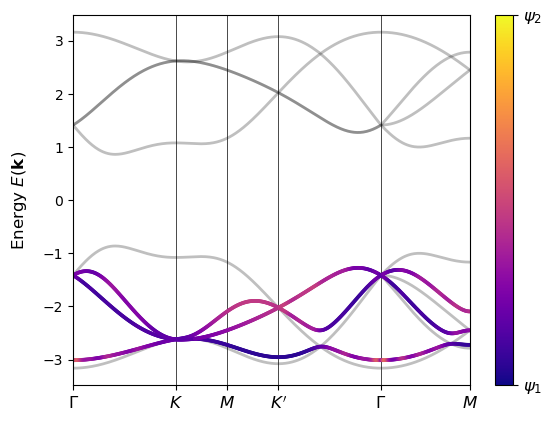

In [19]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')

# Ploting Wannier interpolated bands
fig, ax = WF.tilde_states.plot_interp_bands(
    k_path, nk=501, k_label=k_label, red_lat_idx=high_E_sites, cmap='plasma')

# Plotting actual bands for comparison
(k_vec, k_dist, k_node) = model.k_path(k_path, 501, report=False)
evals, evecs = model.solve_ham(k_vec, return_eigvecs=True)
n_eigs = evecs.shape[-2]
for n in range(evals.shape[-1]):
    ax.plot(k_dist, evals[:, n], c='k', lw=2, zorder=0, alpha=0.25)

If we like, these interpolated energies and eigenstates are also directly accesible using `interp_energies` and the optional flag `ret_eigvecs` to obtain the eigenvectors.

In [20]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 501, report=False)

# Reduced Wannier interpolated energies and states
interp_energies, interp_unk = WF.interp_energies(k_vec, ret_eigvecs=True)